In [60]:
using JuMP, Gurobi, Random, CSV, DataFrames, Statistics, JLD2, FileIO, DelimitedFiles

model_type="model_with_k";
include("display.jl")
include("model.jl");
include("run.jl");
include("../../data/map_inputs.jl");

### Inputs

In [33]:
# Map Inputs
map_type="unif_map_1";

# Model Inputs
G = 2 # max detour ratio for customers (traveling time < (1+G)gamma)
Gtype= "shortestpathpercent" # or "absolutetime"
Q = 10

map_inputs,Wk=create_inputs(map_type);
(map_title,hubs_id,vbs_id,nb_locs,cust_id,nb_cust,depot_locs,horizon,tstep)=map_inputs

model_inputs = (G,Gtype,Wk,Q);

### Display map & create network

In [34]:
data, map1, tsnetwork, params, abbrev = create_network(map_inputs, model_inputs);
q, t, I, K=abbrev;

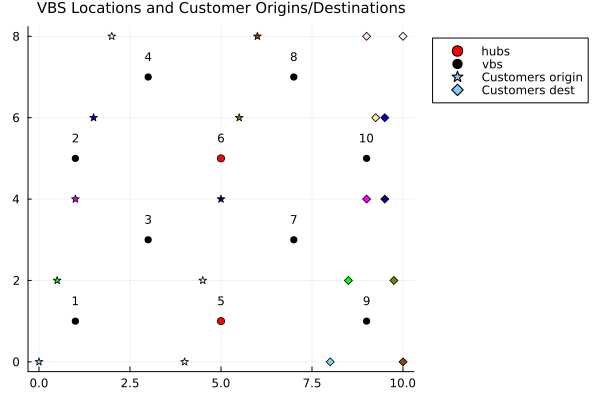

Cust 1, load 1 - Pick-up vbs: [1], Drop-off vbs: [5, 7, 9], 	 depart at: 0.0, arrival before: 200
Cust 2, load 1 - Pick-up vbs: [1, 2, 3], Drop-off vbs: [7, 9, 10], 	 depart at: 5.0, arrival before: 200
Cust 3, load 1 - Pick-up vbs: [1, 2, 3], Drop-off vbs: [7, 9, 10], 	 depart at: 10.0, arrival before: 200
Cust 4, load 1 - Pick-up vbs: [2, 4], Drop-off vbs: [8, 10], 	 depart at: 15.0, arrival before: 200
Cust 5, load 1 - Pick-up vbs: [2, 4], Drop-off vbs: [8, 10], 	 depart at: 20.0, arrival before: 200
Cust 6, load 1 - Pick-up vbs: [1, 3, 5], Drop-off vbs: [8, 10], 	 depart at: 0.0, arrival before: 200
Cust 7, load 1 - Pick-up vbs: [3, 5, 6, 7], Drop-off vbs: [8, 10], 	 depart at: 5.0, arrival before: 180.0
Cust 8, load 1 - Pick-up vbs: [3, 5, 6, 7], Drop-off vbs: [7, 9, 10], 	 depart at: 10.0, arrival before: 150.0
Cust 9, load 1 - Pick-up vbs: [4, 6, 8], Drop-off vbs: [7, 9, 10], 	 depart at: 15.0, arrival before: 200.0
Cust 10, load 1 - Pick-up vbs: [4, 6, 8], Drop-off vbs: [9], 	 

In [35]:
# Show map
display(map1)
print_cust_bus_details(params,abbrev,depot_locs)

In [36]:
# Print number of nodes and arcs
#print_nb_arcs(tsnetwork,params,I)


In [57]:
# To visualize some arcs
#timespaceviz_arcs("viz.png", horizon, tstep, tsnetwork, tsnetwork.A_plus[56], x_size=2000, y_size=1000)

### Run model & Save results

In [37]:
# Model objective coefficients
mu=1 # coefficient in front of walking time
beta=1 # coefficient in front of waiting time
lambda=1 # transfer penalty
alpha1=0.01 # coefficient in front of vehicle driving time and utilization 
nu=20 # coefficient in front of vehicle utilization
alpha2=0 # coefficient in front of unmet demand
coefficients=mu,beta,lambda,alpha1,nu,alpha2;

In [38]:
sol=network_model(Q,abbrev,data.wo,tsnetwork,params,coefficients,0);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Objective value: 953.5002059024345


Save solution

In [45]:
save_res = true; # to save the results in the result folder
resultfolder="../../results/"*model_type*"/"*map_type*"/";
if save_res
    if !isdir(resultfolder)
        mkdir(resultfolder)
    end
    resultfile=resultfolder*"Q"*string(Q)*"_Wk"*string(Wk)
    jldsave(resultfile*".jld2", xi=sol.xi, x=sol.x, z=sol.z)
    write_result(resultfile,sol,tsnetwork,params,abbrev,data.wo,false)
end

### Visualizations

In [62]:
#xi,x,z=load(result_file*".jld2", "xi", "x", "z");

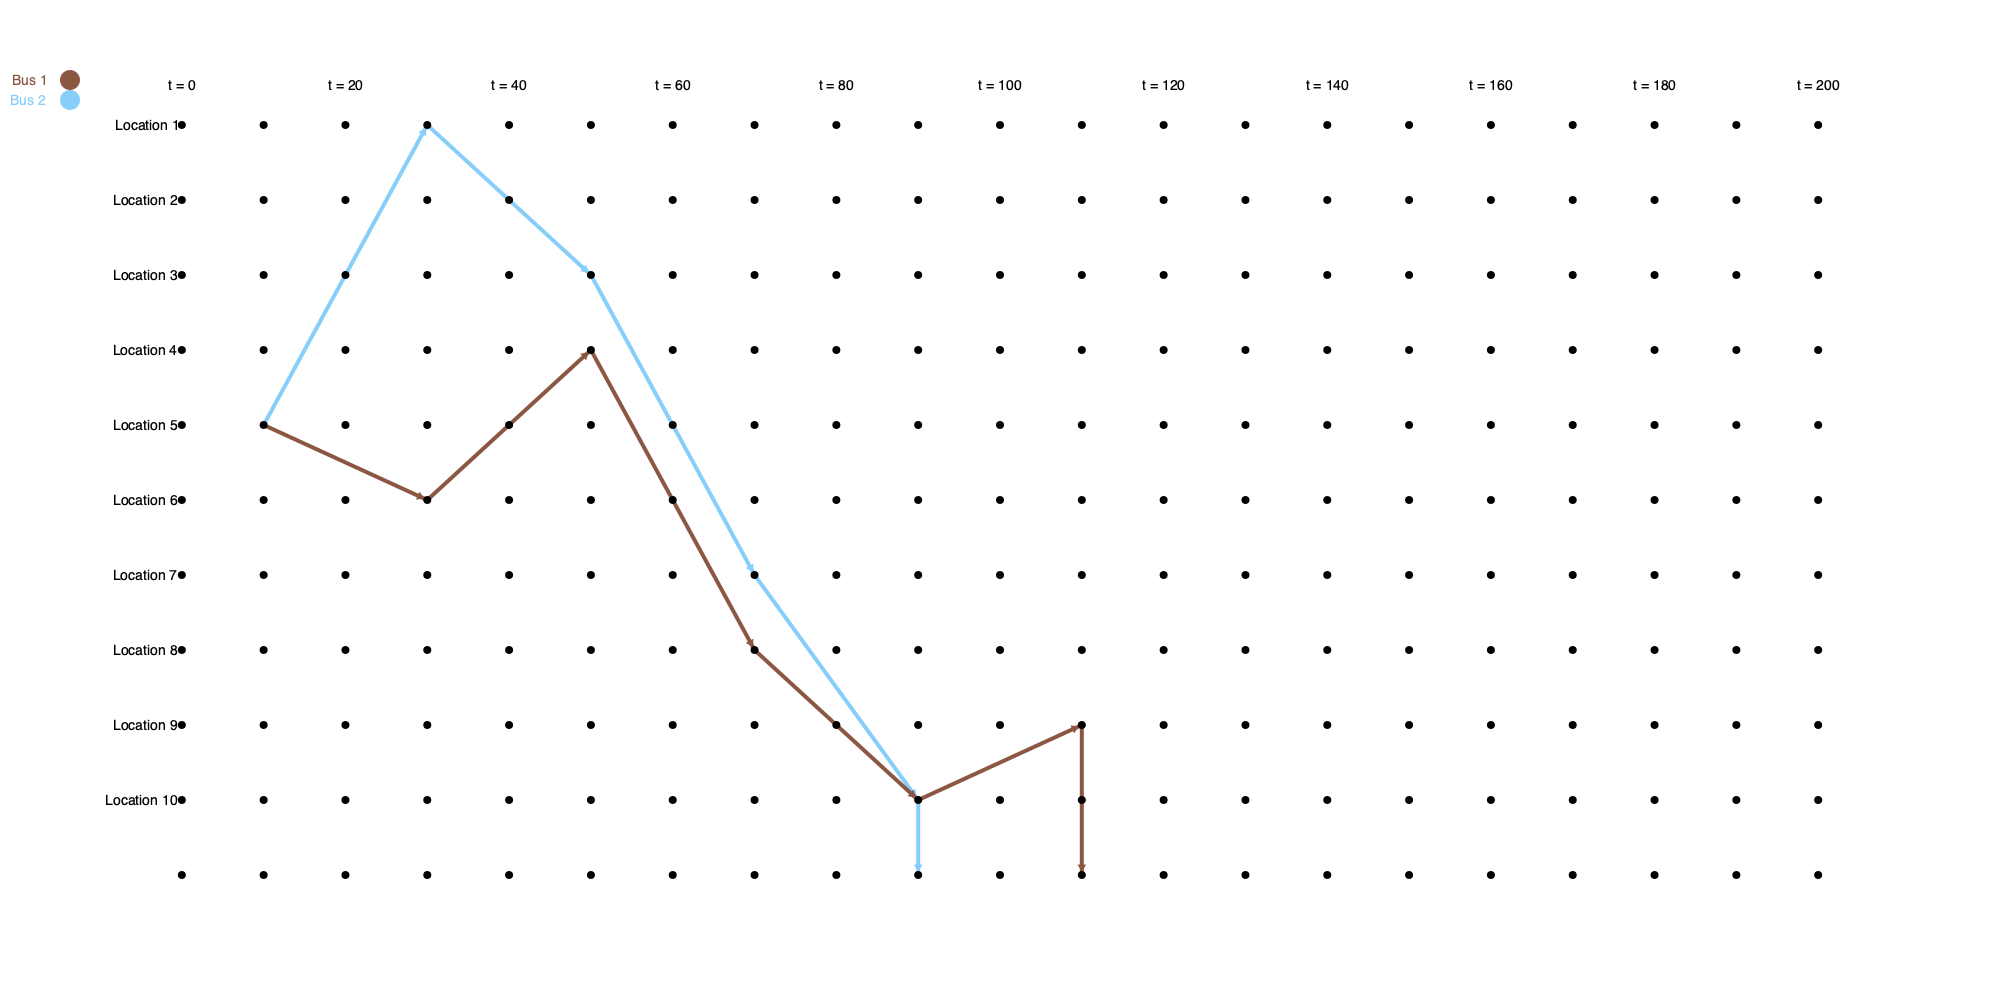

In [53]:
timespaceviz_bus(resultfile*"_tsplot.png", horizon, tstep, tsnetwork, sol.z, x_size=2000, y_size=1000)

Traveling arcs used:
-- Bus 1: 


	 Time 10: from loc 5 to 6
	 Time 30: from loc 6 to 4, with cust [8]
	 Time 50: from loc 4 to 8, with cust [4, 5, 8]
	 Time 70: from loc 8 to 10, with cust [8, 9, 10]
	 Time 90: from loc 10 to 9, with cust [10]
	 Time 110: from loc 9 to 11
-- Bus 2: 
	 Time 10: from loc 5 to 1
	 Time 30: from loc 1 to 3, with cust [1]
	 Time 50: from loc 3 to 7, with cust [1, 2, 3, 6]
	 Time 70: from loc 7 to 10, with cust [6, 7]
	 Time 90: from loc 10 to 11


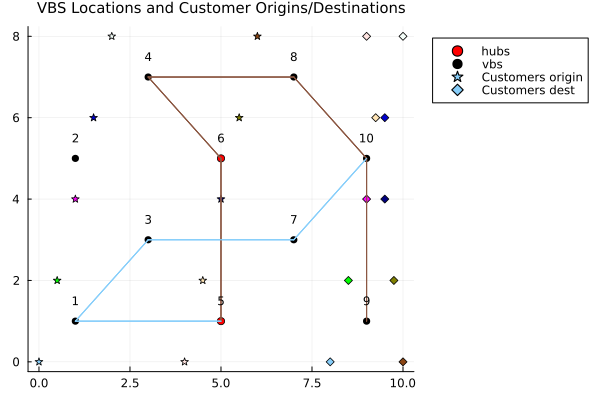

In [61]:
ts=0 # time from which we want to print the arcs
map2=print_traveling_arcs(sol,ts,params,K,map1,data.locs,tsnetwork,true,save_res,resultfile)